In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import os
from sklearn.preprocessing import MinMaxScaler
import ast

В папке parser мы скачали биржевые данные сырьевых компаний и некоторые фьючерсы. Попробуем проанализировать насколько они соотносятся с историческими ценами на на наши товары и могут помочь нам в предсказании.

## Предобработка файлов

In [2]:
df = pd.read_excel('datamon.xlsx')
df['Дата поставки']=pd.to_datetime(df['Дата поставки'])
df['Дата заказа'] = pd.to_datetime(df['Дата заказа'])

print(df.shape)
top = pd.read_excel('toplist.xlsx')
print(top.shape)

(4015, 11)
(21, 1)


In [3]:
df= df[df['Дата поставки'].notna()]

В данных есть записи без Даты заказа и срока поставки. Заполняем пропуске в сроке поставке медианным значением времени доставки по данному наименованию товара. Затем высчитываем дату заявки.

In [4]:
df["Срок поставки"] = df["Срок поставки"].fillna(df.groupby("Наименование")["Срок поставки"].transform('median'))
df['Дата заказа']=df['Дата заказа'].fillna(df['Дата поставки'] - pd.to_timedelta(df['Срок поставки'], unit='d') )
df['Дата заказа'] = pd.to_datetime(df['Дата заказа']).dt.date
df = df.sort_values('Дата заказа')

В данных есть 'задвоенные заказы', удалим их что бы не было лика.

In [5]:
print(df.shape)
df= df[df['Дата поставки'].notna()]
df = df.drop_duplicates(subset = ['Наименование','Дата поставки', 'Цена, руб']).drop_duplicates(subset = ['Наименование','Дата заказа', 'Цена, руб'])
df = df[df['Дата заказа'].notna()]
df['Дата заказа'] =pd.to_datetime(df['Дата заказа'])
print(df.shape)

(4005, 11)
(3164, 11)


## Анализ

Добавляем биржевые показатели на момент заказа к таблице.

In [7]:
def aggregate_new_source(df, add):
    add.index= pd.to_datetime(add.index)
    df = df.merge(add, how = 'left', left_on ='Дата заказа', right_index= True)
    return df

In [8]:
for file_name in os.listdir('parser/basic_matrials_load/'):
    if 'csv' in file_name:
        add = pd.read_csv(os.path.join('parser/basic_matrials_load/', file_name), index_col =0)
        df = aggregate_new_source(df, add)
        print(file_name)
    

IBRIGST.BO.csv
BHARATWIRE.BO.csv
APCL.BO.csv
SARDAEN.BO.csv
NEXA.csv
CENTEXT.BO.csv
LAC.csv
INVPRECQ.BO.csv
BEEKAY.BO.csv
HINDALUMI.BO.csv
RATHIBAR.BO.csv
VASWANI.BO.csv
TINPLATE.BO.csv
TNSTLTU.BO.csv
MSPL.BO.csv
CRH.csv
MDRNSTL.BO.csv
VALE.csv
BIRLACORPN.BO.csv
STARLIT.BO.csv
BCC.csv
VEDL.BO.csv
ROHITFERRO.BO.csv
FACORALL.BO.csv
ASHAPURMIN.BO.csv
ACC.BO.csv
GOPAIST.BO.csv
AML.BO.csv
SAGCEM.BO.csv
NCLIND.BO.csv
BHP.csv
BAROEXT.BO.csv
ISMTLTD.BO.csv
BVN.csv
TMST.csv
UMIYA.BO.csv
KAMDHENU.BO.csv
INDSILHYD.BO.csv
USAU.csv
SA.csv
METC.csv
SHREMETAL.BO.csv
VSSL.BO.csv
BEDMUTHA.BO.csv
RAJGLOWIR.BO.csv
CPAC.csv
INDIACEM.BO.csv
PAAS.csv
UNIABEXAL.BO.csv
JSL.BO.csv
IFGLEXPOR.BO.csv
HL-PB.csv
UTTAMSTL.BO.csv
KRIINFRA.BO.csv
HISARMET.BO.csv
ANKITMETAL.BO.csv
MANAKSTELTD.BO.csv
SATINDLTD.BO.csv
NORTHLINK.BO.csv
SANDUMA.BO.csv
USHAMART.BO.csv
RISHDIGA.BO.csv
NMG.csv
METALCO.BO.csv
CREATIVE.BO.csv
JINDALSTEL.BO.csv
INDINFRA.BO.csv
GMETCOAL.BO.csv
RAMCOCEM.BO.csv
ASHSI.BO.csv
GFI.csv
USLM.csv
SOUTHMG

In [9]:
for file_name in os.listdir('parser/basic_futures_and_other_load/'):
    if 'csv' in file_name:
        add = pd.read_csv(os.path.join('parser/basic_futures_and_other_load/', file_name), index_col =0)
        df = aggregate_new_source(df, add)
        print(file_name)

HDG=F.csv
GC=F.csv
SI=F.csv
HG=F.csv
HO=F.csv
CL=F.csv
RUB=X.csv


Построим таблицу корреляций каждого товара с биржевыми индексами.
Мы высчитываем корреляцию между ценой товара в каждый день заказа данного товара и биржевой катировкой в этот день.

In [10]:
list_df = []
t = df[['Наименование','Цена, руб']+ list(df.columns)[13:]]
for name in top['товары'].unique():
    list_df.append(t[t['Наименование']==name].corr()['Цена, руб'].drop('Цена, руб').rename(name))
corr_df = pd.concat(list_df,axis=1)

corr_df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,Зуб 1085.52.05-1,Колесо 3519.05.02.006,Вал 3536.11.01.002,Вал 3519.05.02.083,Ось 3519.21.00.025,Коромысло 3519.21.00.023,Вал 3572.05.10.200,Вант стрелы 00.1606.49.1,Засов 3532.01.02.007,Вал 3572.05.10.150,Сателлит 3536.11.01.028,ВАЛ-ШЕСТЕРНЯ 3536.11.01.002,Вал 3532.10.01.011,Зуб 1085.52.05-1,Колесо 3519.05.02.003,Ось 3519.05.02.082,Ось 3519.05.02.081,Колесо 3519.05.02.061,Вал 3519.05.02.007,Ось 3536.03.00.001,Коромысло 3537.25.00.500
APCL.BO,0.248852,-0.051550,0.090364,0.376581,0.109539,-0.547602,-0.813086,0.244904,0.547213,0.014994,-0.368529,0.625083,-0.026671,-0.241862,-0.654348,-0.301884,-0.153346,0.182882,-0.204406,-0.542132,0.023459
SARDAEN.BO,0.091360,0.023034,-0.046135,0.245717,0.206344,-0.564766,-0.534997,0.158146,0.433850,0.172181,-0.134446,0.970628,0.100471,-0.395673,-0.659466,-0.249178,-0.173902,0.262413,-0.141739,-0.635877,-0.028076
NEXA,-0.211267,0.164555,-0.308704,-0.487840,0.398342,-0.432348,0.143581,-0.329670,-0.526707,0.377089,-0.118226,nan,0.334758,-0.373471,-0.142207,0.499417,-0.167667,0.538021,-0.537307,-0.516525,0.132852
CENTEXT.BO,-0.112062,0.041094,-0.130133,0.143263,0.509588,-0.133962,-0.086299,0.346859,0.301490,-0.043791,0.414124,0.927440,0.357076,0.096994,-0.359278,-0.121635,-0.215892,0.249889,0.039824,-0.127579,0.002398
LAC,0.282024,-0.103139,0.211168,0.325337,-0.112838,-0.496537,-0.739060,-0.345005,0.546224,0.037666,-0.257714,0.364688,-0.092991,-0.209412,-0.775548,-0.193404,0.050680,0.036911,-0.222307,-0.612078,0.258340
INVPRECQ.BO,-0.378100,0.263823,-0.416388,0.030097,0.325302,-0.399182,0.160711,0.219556,-0.192612,0.409070,0.141684,0.731554,0.415067,-0.250197,-0.266577,0.283322,-0.380242,0.497873,0.107831,-0.389779,0.050803
BEEKAY.BO,-0.120758,0.115548,-0.271546,-0.004427,0.595823,-0.180982,0.050804,0.065918,0.162295,0.046881,0.553895,0.921461,0.534118,-0.266640,-0.504407,0.110599,0.065495,0.627204,-0.263930,-0.159668,-0.009519
HINDALUMI.BO,-0.531695,0.140582,-0.489484,-0.201676,0.356000,-0.460371,0.325229,0.077783,-0.550937,0.304668,0.155827,0.151054,0.340671,-0.123072,0.105205,0.204895,-0.391535,0.503136,0.191229,0.255763,0.346451
RATHIBAR.BO,0.071537,0.061432,-0.108289,0.237664,0.257817,-0.495595,-0.360977,-0.011635,0.097570,0.319811,-0.327677,0.936525,0.279797,-0.494073,-0.710131,0.039471,-0.278207,0.382348,-0.163059,-0.725029,-0.002723
VASWANI.BO,-0.207783,0.024592,-0.172721,0.093753,0.348213,-0.426220,-0.034735,0.042365,0.108203,0.273287,0.090981,0.736383,0.318888,-0.487356,-0.571803,0.310368,-0.354145,0.533405,0.232598,-0.506369,-0.071870


Мы видим что некоторые товары слиьно коррелирут с разными биржевыми котировками, некоторые почти не коррелируют.

In [11]:
df[df['Наименование']=='ВАЛ-ШЕСТЕРНЯ 3536.11.01.002 '].corr()['Цена, руб'].dropna().sort_values()

Поставщик       -0.996527
SHBAJRG.BO      -0.970727
ASHAPURMIN.BO   -0.904879
SURAJLTD.BO     -0.867099
NORTHLINK.BO    -0.866578
                   ...   
KACHCHH.BO       0.988418
NOVIS.BO         0.990439
ARFIN.BO         0.992533
IMFA.BO          0.996763
Цена, руб        1.000000
Name: Цена, руб, Length: 262, dtype: float64

Для каждого наименвоания товаров составим наиболее коррелирующие компании будем брать показатели корреляции более 0.8 и менее -0.8

In [14]:
t = df[['Наименование','Цена, руб']+ list(df.columns)[13:]]
for name in top['товары'].unique():
    cor = t[t['Наименование']==name].corr()['Цена, руб'].sort_values().dropna()
    cor = cor.drop(['Цена, руб'])
    pos_cor = list( cor[(cor>0.8)].index )
    neg_cor = list( cor[(cor<-0.8)].index )
    
    top.loc[top['товары']==name,'positive_corelated'] = str(pos_cor)
    top.loc[top['товары']==name,'negative_corelated'] = str(neg_cor)
    


In [15]:
top

,товары,positive_corelated,negative_corelated
0,Зуб 1085.52.05-1,[],[]
1,Колесо 3519.05.02.006,[],['SHYAMMETL.BO']
2,Вал 3536.11.01.002,[],['SHYAMMETL.BO']
3,Вал 3519.05.02.083,"['AMR', 'HUDI', 'HDG=F']",['SHYAMMETL.BO']
4,Ось 3519.21.00.025,['AMR'],"['NSR', 'HUDI', 'NMG']"
5,Коромысло 3519.21.00.023,[],[]
6,Вал 3572.05.10.200,['NSR'],"['SHBAJRG.BO', 'PTCIL.BO', 'FCX', 'JKCEMENT.BO..."
7,Вант стрелы 00.1606.49.1,[],[]
8,Засов 3532.01.02.007,[],[]
9,Вал 3572.05.10.150,"['AMR', 'ASTL']","['SHYAMMETL.BO', 'NSR']"


In [16]:
df.to_csv('datamon_with_indexes.csv')

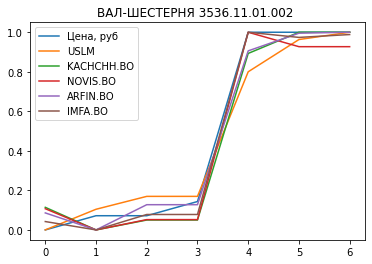

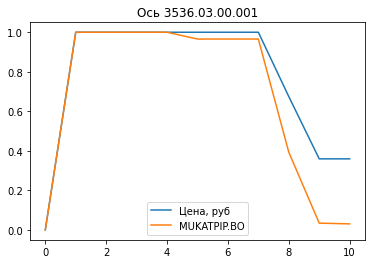

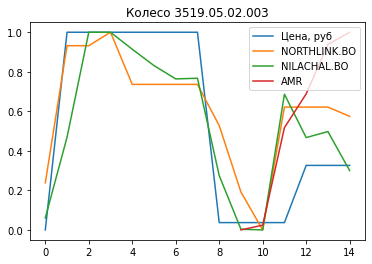

In [66]:
top['positive_corelated']= top['positive_corelated'].apply(ast.literal_eval)
for name in ['ВАЛ-ШЕСТЕРНЯ 3536.11.01.002 ', 'Ось 3536.03.00.001', 'Колесо 3519.05.02.003']:
    list_of_correlated = top.loc[top['товары']==name,'positive_corelated'].reset_index(drop=True)[0][-5:]
    if list_of_correlated !=[]:
        t = df[df['Наименование']==name]
        scaler = MinMaxScaler()
        t_scaled = pd.DataFrame(scaler.fit_transform(t[['Цена, руб']+list_of_correlated]), columns=['Цена, руб']+list_of_correlated)
        t_scaled[['Цена, руб']+list_of_correlated].plot(title=name)

